# BEST CITY TO ALLOCATE A GAMING COMPANY

## Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import math
import os
from dotenv import load_dotenv

from pymongo import MongoClient

import geopandas as gpd
from geopy.distance import distance
from geopy.distance import geodesic 
from shapely.geometry import Point
from geopy.distance import great_circle
from descartes import PolygonPatch

import matplotlib.pyplot as plt
%matplotlib inline

from cartoframes.viz import Map, Layer
from cartoframes.viz.helpers import size_continuous_layer
from cartoframes.viz.widgets import histogram_widget

import folium
from folium import plugins
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster


## MongoDB

In [171]:
#Importing companies.json from mongodb.
client = MongoClient("mongodb://localhost/companies")
db = client.get_database()

In [172]:
#Importing information about companies from MongoDB.
query={"$and":[{"category_code":{"$eq":"games_video"}},{"number_of_employees":{"$gte":10}}]}
list_companies=list(db['companies'].find((query),{"category_code":1,'number_of_employees':1,'name':1,"total_money_raised":1,"offices":1,'_id':0}).sort("number_of_employees",-1))

In [173]:
#Converting the info into 'pandas'
df = pd.DataFrame(list_companies)

In [174]:
#Removing duplicates.
df = df.drop_duplicates(subset='name', keep='first')

In [175]:
#Removing the NAN values from offices column.
df.dropna(subset=['offices'], inplace=True)

In [176]:
df

name category_code  number_of_employees  \
0                    Comcast   games_video               100000   
1    The Walt Disney Company   games_video                25000   
2                   Nintendo   games_video                 5080   
3                       DeNA   games_video                 2192   
5                    Netflix   games_video                 2000   
..                       ...           ...                  ...   
232                  ToonUps   games_video                   10   
233                   BIT TV   games_video                   10   
234              Campus Jerk   games_video                   10   
235              ekidnaworld   games_video                   10   
236          Digital Nasties   games_video                   10   

    total_money_raised                                            offices  
0                $725M  [{'description': 'One Comcast Center', 'addres...  
1                   $0  [{'description': None, 'address1': '500 S. Bue...  
2                   $0  [{'description': None, 'address1': None, 'addr...  
3               ¥2.21B  [{'description': 'Headquarters', 'address1': '...  
5                $230M  [{'description': None, 'address1': '100 Winche...  
..                 ...                                                ...  
232                 $0  [{'description': 'Corporate', 'address1': '11 ...  
233                 $0  [{'description': 'Main Office', 'address1': '4...  
234                 $0                                                 []  
235                 $0  [{'description': '', 'address1': 'Fortitude Va...  
236                 $0                                                 []  

[229 rows x 5 columns]

In [177]:
#Removing the lists from offices column 
df = df.explode('offices')
df

name category_code  number_of_employees  \
0                    Comcast   games_video               100000   
1    The Walt Disney Company   games_video                25000   
2                   Nintendo   games_video                 5080   
3                       DeNA   games_video                 2192   
5                    Netflix   games_video                 2000   
..                       ...           ...                  ...   
232                  ToonUps   games_video                   10   
233                   BIT TV   games_video                   10   
234              Campus Jerk   games_video                   10   
235              ekidnaworld   games_video                   10   
236          Digital Nasties   games_video                   10   

    total_money_raised                                            offices  
0                $725M  {'description': 'One Comcast Center', 'address...  
1                   $0  {'description': None, 'address1': '500 S. Buen...  
2                   $0  {'description': None, 'address1': None, 'addre...  
3               ¥2.21B  {'description': 'Headquarters', 'address1': 'S...  
5                $230M  {'description': None, 'address1': '100 Winches...  
..                 ...                                                ...  
232                 $0  {'description': 'Corporate', 'address1': '11 W...  
233                 $0  {'description': 'Main Office', 'address1': '47...  
234                 $0                                                NaN  
235                 $0  {'description': '', 'address1': 'Fortitude Val...  
236                 $0                                                NaN  

[293 rows x 5 columns]

In [191]:
exapand_office_column = df[["offices"]].apply(lambda r: r.offices, result_type="expand", axis=1)
data_expanded = pd.concat([df,exapand_office_column], axis=1)
data_expanded.head()

name category_code  number_of_employees  \
0                  Comcast   games_video               100000   
1  The Walt Disney Company   games_video                25000   
2                 Nintendo   games_video                 5080   
3                     DeNA   games_video                 2192   
5                  Netflix   games_video                 2000   

  total_money_raised                                            offices  \
0              $725M  {'description': 'One Comcast Center', 'address...   
1                 $0  {'description': None, 'address1': '500 S. Buen...   
2                 $0  {'description': None, 'address1': None, 'addre...   
3             ¥2.21B  {'description': 'Headquarters', 'address1': 'S...   
5              $230M  {'description': None, 'address1': '100 Winches...   

          description                 address1             address2  zip_code  \
0  One Comcast Center            1701 JFK Blvd                          19103   
1                None   500 S. Buena Vista St.                          91521   
2                None                     None                 None      None   
3        Headquarters  Shibuya Hikarie, 2-21-1  Shibuya, Shibuya-ku  150-8510   
5                None    100 Winchester Circle                          95032   

           city state_code country_code   latitude   longitude  
0  Philadelphia         PA          USA  39.952576  -75.165252  
1       Burbank         CA          USA  34.156802 -118.324987  
2          None       None          JPN  36.204824  138.252924  
3         Tokyo       None          JPN        NaN         NaN  
5     Los Gatos         CA          USA  37.251420 -121.968687

In [8]:
#Removing old column with lists.
df_companies = data_expanded.drop(columns=["offices"])

In [9]:
#Removing the NAN long and latt columns.
df_companies.dropna(subset=['latitude'], inplace=True)
df_companies.dropna(subset=['longitude'], inplace=True)

## TOP 5 CITIES WITH MORE GAMING COMPANIES

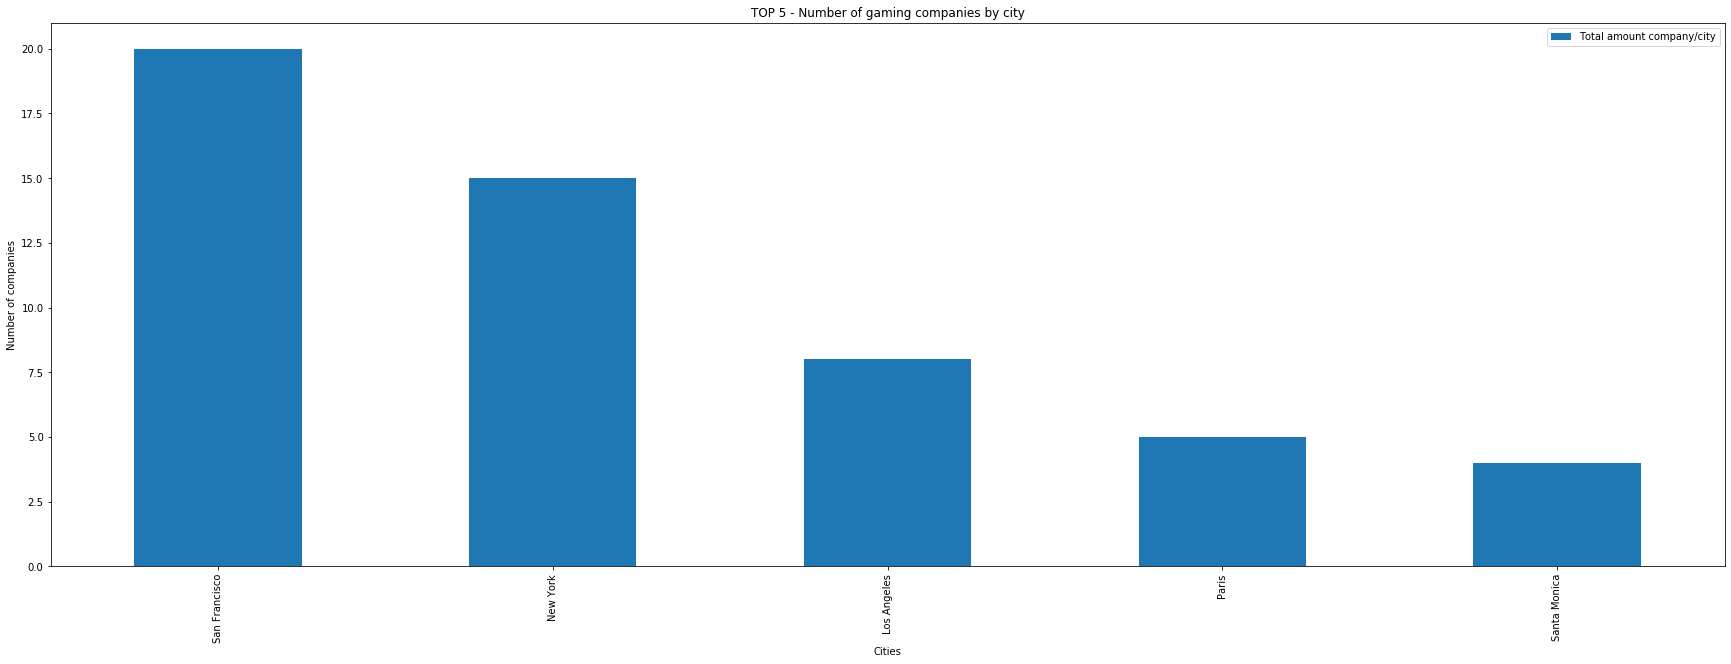

In [10]:
#TOP5 cities with more companies with 'category code' = 'video_games'

graph_df=df_companies[['city','name']]
graphic= graph_df.groupby('city').count().sort_values('name',ascending = False).head()

graphic.plot.bar(figsize=(30,10));
plt.legend(["Total amount company/city"])
plt.title("TOP 5 - Number of gaming companies by city")
plt.xlabel("Cities")
plt.ylabel("Number of companies");

## Convertig DataFrame into GeoDataFrame

In [11]:
gdf = gpd.GeoDataFrame(df_companies, geometry=gpd.points_from_xy(df_companies.longitude, df_companies.latitude))
gdf.head()

name category_code  number_of_employees  \
0                  Comcast   games_video               100000   
1  The Walt Disney Company   games_video                25000   
2                 Nintendo   games_video                 5080   
5                  Netflix   games_video                 2000   
9                    Kabam   games_video                  650   

  total_money_raised         description                address1   address2  \
0              $725M  One Comcast Center           1701 JFK Blvd              
1                 $0                None  500 S. Buena Vista St.              
2                 $0                None                    None       None   
5              $230M                None   100 Winchester Circle              
9              $125M                  HQ       795 Folsom Street  Suite 600   

  zip_code           city state_code country_code   latitude   longitude  \
0    19103   Philadelphia         PA          USA  39.952576  -75.165252   
1    91521        Burbank         CA          USA  34.156802 -118.324987   
2     None           None       None          JPN  36.204824  138.252924   
5    95032      Los Gatos         CA          USA  37.251420 -121.968687   
9    94107  San Francisco         CA          USA  37.394456 -122.078531   

                      geometry  
0   POINT (-75.16525 39.95258)  
1  POINT (-118.32499 34.15680)  
2   POINT (138.25292 36.20482)  
5  POINT (-121.96869 37.25142)  
9  POINT (-122.07853 37.39446)

In [12]:
Map([Layer(gdf), size_continuous_layer(gdf, 'number_of_employees')])

## MAPS BY CITY

### GEOCODE API: 
NEEDED FUNCTION IN ORDER TO EXTRACT COORDINATES:

In [56]:
def geocode(address):
    data = requests.get(f"https://geocode.xyz/{address}?json=1").json()
    return {
        "type":"Point",
        "coordinates":[float(data["longt"]),float(data["latt"])]
    }

In [57]:
sf = geocode("San Francisco, CA, USA")
sf

{'type': 'Point', 'coordinates': [-122.40438, 37.66873]}

In [58]:
def withGeoQuery(location,maxDistance=15000,minDistance=0,field="location"):
    return {
       field: {
         "$near": {
           "$geometry": location if type(location)==dict else geocode(location),
           "$maxDistance": maxDistance,
           "$minDistance": minDistance
         }
       }
    }

In [59]:
query = withGeoQuery(sf)

In [60]:
comp = list(db["cleancompanies"].find(query))
print(len(comp))

18


In [61]:
query = withGeoQuery(ny)
comp = list(db["cleancompanies"].find(query))
print(len(comp))

0


In [ ]:
query = withGeoQuery(ny)
comp = list(db["cleancompanies"].find(query))
print(len(comp))

### 1 - SAN FRANCISCO

In [17]:
start_lat = 37.66873
start_lon = -122.40438
heat_m_sf = folium.Map(location=[start_lat, start_lon],tiles='cartodbpositron', zoom_start=15)
Marker([start_lat, start_lon], icon=folium.Icon(color='lightgreen')).add_to(heat_m_sf)

In [18]:
companies = gdf
companies_group = folium.FeatureGroup(name="Gaming Companies")
HeatMap(data=companies[['latitude', 'longitude']],radius=15).add_to(companies_group)
companies_group.add_to(heat_m_sf)
heat_m_sf

In [19]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='San Francisco Airport USA'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()

lat_sf_airport=(data['results'][0]['geometry']['location']['lat'])
long_sf_airport=(data['results'][0]['geometry']['location']['lng'])
print(lat_sf_airport)
print(long_sf_airport)

Python-dotenv could not parse statement starting at line 2


37.6213129
-122.3789554


In [20]:
heat_m_sf.add_child(Marker([lat_sf_airport, long_sf_airport], icon=folium.Icon(color='lightblue')))
heat_m_sf

In [21]:
#KM between airport & city
sf = (37.66873,-122.40438) 
airport_sf = (37.6213129,-122.3789554) 
print(great_circle(sf, airport_sf).km)

5.728065177954947


### 2 - NEW YORK

In [22]:
ny = geocode("New York")
query = withGeoQuery(ny)
comp = list(db["cleancompanies"].find(query))
print(len(comp))

0


In [23]:
start_lat = 40.689081
start_lon = -73.9586
heat_m_ny = folium.Map(location=[start_lat, start_lon],tiles='cartodbpositron', zoom_start=15)
Marker([start_lat, start_lon], icon=folium.Icon(color='red')).add_to(heat_m_ny)

In [89]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")

address='New York Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_ny_airport=(data['results'][0]['geometry']['location']['lat'])
long_ny_airport=(data['results'][0]['geometry']['location']['lng'])
print(lat_ny_airport)
print(long_ny_airport)

Python-dotenv could not parse statement starting at line 2


40.6413111
-73.77813909999999


In [90]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")

address='Newark Airport USA'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_newark_airport=(data['results'][0]['geometry']['location']['lat'])
long_newark_airport=(data['results'][0]['geometry']['location']['lng'])
print(lat_newark_airport)
print(long_newark_airport)

Python-dotenv could not parse statement starting at line 2


40.6895314
-74.1744624


In [91]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")

address='LaGuardia Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_laguardia_airport=(data['results'][0]['geometry']['location']['lat'])
long_laguardia_airport=(data['results'][0]['geometry']['location']['lng'])
print(lat_laguardia_airport)
print(long_laguardia_airport)

Python-dotenv could not parse statement starting at line 2


40.7769271
-73.8739659


In [87]:
companies = gdf
companies_group = folium.FeatureGroup(name="Gaming Companies")
HeatMap(data=companies[['latitude', 'longitude']],radius=15).add_to(companies_group)
companies_group.add_to(heat_m_ny)

In [92]:
heat_m_ny.add_child(Marker([lat_ny_airport, long_ny_airport], icon=folium.Icon(color='lightblue')))
heat_m_ny.add_child(Marker([lat_laguardia_airport, long_laguardia_airport], icon=folium.Icon(color='lightblue')))
heat_m_ny.add_child(Marker([lat_newark_airport,lat_newark_airport], icon=folium.Icon(color='lightblue')))

In [29]:
#KM between airport & city
ny = (40.689081,-73.9586) 
airport_ny = (40.6413111,-73.7767901197085) 
print(great_circle(ny, airport_ny).km)

16.228637161599178


### 3 - LOS ANGELES

In [69]:
la = geocode("Los Angeles")
la

{'type': 'Point', 'coordinates': [-118.29757, 34.04015]}

In [70]:
query = withGeoQuery(la)
comp = list(db["cleancompanies"].find(query))
print(len(comp))

12


In [71]:
start_lat = 34.04015
start_lon = -118.29757
heat_m_la = folium.Map(location=[start_lat, start_lon],tiles='cartodbpositron', zoom_start=15)
Marker([start_lat, start_lon], icon=folium.Icon(color='green')).add_to(heat_m_la)

In [72]:
companies = gdf
companies_group = folium.FeatureGroup(name="Gaming Companies")
HeatMap(data=companies[['latitude', 'longitude']],radius=15).add_to(companies_group)
companies_group.add_to(heat_m_la)

In [94]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='Los Angeles Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_la_airport=(data['results'][0]['geometry']['location']['lat'])
long_la_airport=(data['results'][0]['geometry']['location']['lng'])
print(lat_la_airport)
print(long_la_airport)

Python-dotenv could not parse statement starting at line 2


33.9415889
-118.40853


In [95]:
la_air_long, la_air_lat = -118.4071810197085, 33.9429378802915
heat_m_la.add_child(Marker([lat_la_airport, long_la_airport], icon=folium.Icon(color='lightblue')))

In [65]:
#KM between airport & city

la = (34.04015,-118.29757) 
airport_la = (33.9429378802915,-118.4071810197085) 
print('Km from LA to LA Airport =', great_circle(la, airport_la).km)

Km from LA to LA Airport = 14.797509925938781


### 4 - PARIS

In [156]:
paris = geocode("Paris")
paris

{'type': 'Point', 'coordinates': [2.34293, 48.85717]}

In [157]:
start_lat = 48.85717
start_lon = 2.34293
heat_m_paris = folium.Map(location=[start_lat, start_lon],tiles='cartodbpositron', zoom_start=15)
Marker([start_lat, start_lon], icon=folium.Icon(color='pink')).add_to(heat_m_paris)

In [158]:
companies = gdf
companies_group = folium.FeatureGroup(name="Gaming Companies")
HeatMap(data=companies[['latitude', 'longitude']],radius=15).add_to(companies_group)
companies_group.add_to(heat_m_paris)

In [159]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='France Paris Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
print(data)

Python-dotenv could not parse statement starting at line 2


{'results': [{'address_components': [{'long_name': 'Paris-Charles De Gaulle', 'short_name': 'Paris-Charles De Gaulle', 'types': ['airport', 'establishment', 'point_of_interest']}, {'long_name': 'Roissy-en-France', 'short_name': 'Roissy-en-France', 'types': ['locality', 'political']}, {'long_name': 'Île-de-France', 'short_name': 'IDF', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'France', 'short_name': 'FR', 'types': ['country', 'political']}, {'long_name': '95700', 'short_name': '95700', 'types': ['postal_code']}], 'formatted_address': 'Paris-Charles De Gaulle (CDG), 95700 Roissy-en-France, France', 'geometry': {'location': {'lat': 49.0096906, 'lng': 2.5479245}, 'location_type': 'GEOMETRIC_CENTER', 'viewport': {'northeast': {'lat': 49.0110395802915, 'lng': 2.549273480291502}, 'southwest': {'lat': 49.0083416197085, 'lng': 2.546575519708498}}}, 'place_id': 'ChIJW89MjgM-5kcRLKZbL5jgKwQ', 'plus_code': {'compound_code': '2G5X+V5 Roissy-en-France, France', 'global_c

In [160]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='Orly Paris Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
print(data)

Python-dotenv could not parse statement starting at line 2


{'results': [{'address_components': [{'long_name': 'Orly Airport', 'short_name': 'Orly Airport', 'types': ['airport', 'establishment', 'point_of_interest']}, {'long_name': 'Orly', 'short_name': 'Orly', 'types': ['locality', 'political']}, {'long_name': 'Île-de-France', 'short_name': 'IDF', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'France', 'short_name': 'FR', 'types': ['country', 'political']}, {'long_name': '94390', 'short_name': '94390', 'types': ['postal_code']}], 'formatted_address': 'Orly Airport (ORY), 94390 Orly, France', 'geometry': {'location': {'lat': 48.7262433, 'lng': 2.3652472}, 'location_type': 'GEOMETRIC_CENTER', 'viewport': {'northeast': {'lat': 48.7275922802915, 'lng': 2.366596180291502}, 'southwest': {'lat': 48.7248943197085, 'lng': 2.363898219708498}}}, 'place_id': 'ChIJHTtq-rF15kcRIoTbQ9feeJ0', 'plus_code': {'compound_code': 'P9G8+F3 Orly, France', 'global_code': '8FW4P9G8+F3'}, 'types': ['airport', 'establishment', 'point_of_interest']}

In [161]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='Le Bourget Paris Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
print(data)

Python-dotenv could not parse statement starting at line 2


{'results': [{'address_components': [{'long_name': 'Paris Airport-Le Bourget', 'short_name': 'Paris Airport-Le Bourget', 'types': ['airport', 'establishment', 'point_of_interest']}, {'long_name': '1', 'short_name': '1', 'types': ['street_number']}, {'long_name': 'Rue Désiré Lucca', 'short_name': 'Rue Désiré Lucca', 'types': ['route']}, {'long_name': 'Le Bourget', 'short_name': 'Le Bourget', 'types': ['locality', 'political']}, {'long_name': 'Île-de-France', 'short_name': 'IDF', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'France', 'short_name': 'FR', 'types': ['country', 'political']}, {'long_name': '93350', 'short_name': '93350', 'types': ['postal_code']}], 'formatted_address': 'Paris Airport-Le Bourget, 1 Rue Désiré Lucca, 93350 Le Bourget, France', 'geometry': {'location': {'lat': 48.9614725, 'lng': 2.437202}, 'location_type': 'ROOFTOP', 'viewport': {'northeast': {'lat': 48.9628214802915, 'lng': 2.438550980291502}, 'southwest': {'lat': 48.9601235197085, 'ln

In [162]:
paris_air_long, paris_air_lat = 2.445518380291502, 48.9574994802915
heat_m_paris=heat_m_paris.add_child(Marker([paris_air_lat, paris_air_long], icon=folium.Icon(color='lightblue')))

In [163]:
paris_air_long, paris_air_lat = 2.366596180291502, 48.7275922802915
heat_m_paris=heat_m_paris.add_child(Marker([paris_air_lat, paris_air_long], icon=folium.Icon(color='lightblue')))

In [164]:
paris_air_long, paris_air_lat = 2.546575519708498, 49.0083416197085
heat_m_paris.add_child(Marker([paris_air_lat, paris_air_long], icon=folium.Icon(color='lightblue')))

In [ ]:
#KM between airport & city - 'Paris-Charles De Gaulle'

paris = (48.85717,2.34293)
airport_paris = (48.9574994802915,2.445518380291502) 
print(great_circle(paris, airport_paris).km)

In [ ]:
#KM between airport & city - 'Orly Airport'

paris = (48.85717,2.34293)
airport_paris = (48.7275922802915,2.366596180291502) 
print(great_circle(paris, airport_paris).km)

In [ ]:
#KM between airport & city - 'Paris Airport-Le Bourget'

paris = (48.85717,2.34293)
airport_paris = (49.0083416197085,2.546575519708498)
print(great_circle(paris, airport_paris).km)

### 5 - SANTA MONICA

In [80]:
sm = geocode("Santa Monica, CA, USA")
sm

{'type': 'Point', 'coordinates': [-118.48319, 34.02401]}

In [81]:
start_lat = 34.02401
start_lon = -118.48319
heat_m_sm = folium.Map(location=[start_lat, start_lon],tiles='cartodbpositron', zoom_start=15)
Marker([start_lat, start_lon], icon=folium.Icon(color='black')).add_to(heat_m_sm)

In [82]:
companies = gdf
companies_group = folium.FeatureGroup(name="Gaming Companies")
HeatMap(data=companies[['latitude', 'longitude']],radius=15).add_to(companies_group)
companies_group.add_to(heat_m_sm)

In [83]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='Santa Monica Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
print(data)

Python-dotenv could not parse statement starting at line 2


{'results': [{'address_components': [{'long_name': 'Santa Monica Airport', 'short_name': 'Santa Monica Airport', 'types': ['airport', 'establishment', 'point_of_interest']}, {'long_name': '3233', 'short_name': '3233', 'types': ['street_number']}, {'long_name': 'Donald Douglas Loop South', 'short_name': 'Donald Douglas Loop S', 'types': ['route']}, {'long_name': 'Sunset Park', 'short_name': 'Sunset Park', 'types': ['neighborhood', 'political']}, {'long_name': 'Santa Monica', 'short_name': 'Santa Monica', 'types': ['locality', 'political']}, {'long_name': 'Los Angeles County', 'short_name': 'Los Angeles County', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'California', 'short_name': 'CA', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'United States', 'short_name': 'US', 'types': ['country', 'political']}, {'long_name': '90405', 'short_name': '90405', 'types': ['postal_code']}], 'formatted_address': 'Santa Monica Airport, 3233 Donald Dougl

In [96]:
airport_long, airport_lat = -118.4459796197085, 34.01916328029149
heat_m_sm.add_child(Marker([airport_lat, airport_long], icon=folium.Icon(color='lightblue')))

In [77]:
#KM between airport & city
sf = (34.02401,-118.48319) 
airport_sf = (34.01916328029149,-118.4459796197085) 
print(great_circle(sf, airport_sf).km)

3.471452095951666


In [148]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
location="34.02401,-118.48319"
site='nursery'
data=requests.get(f"https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={location}&radius=5000&type={site}&keyword=cruise&key={token}").json()

Python-dotenv could not parse statement starting at line 2


In [154]:
df_nurseries_sm=pd.DataFrame(data['results'])

In [155]:
df_nurseries_sm

geometry  \
0   {'location': {'lat': 34.0140158, 'lng': -118.4...   
1   {'location': {'lat': 34.0075789, 'lng': -118.4...   
2   {'location': {'lat': 34.038395, 'lng': -118.44...   
3   {'location': {'lat': 34.0360665, 'lng': -118.4...   
4   {'location': {'lat': 34.0270738, 'lng': -118.5...   
5   {'location': {'lat': 33.9833085, 'lng': -118.4...   
6   {'location': {'lat': 34.0513424, 'lng': -118.4...   
7   {'location': {'lat': 34.0489339, 'lng': -118.4...   
8   {'location': {'lat': 33.9795191, 'lng': -118.4...   
9   {'location': {'lat': 34.0365689, 'lng': -118.4...   
10  {'location': {'lat': 33.9816074, 'lng': -118.4...   
11  {'location': {'lat': 33.979271, 'lng': -118.43...   
12  {'location': {'lat': 33.984026, 'lng': -118.45...   
13  {'location': {'lat': 33.983359, 'lng': -118.44...   
14  {'location': {'lat': 33.98492100000001, 'lng':...   
15  {'location': {'lat': 34.0484137, 'lng': -118.4...   
16  {'location': {'lat': 33.9817786, 'lng': -118.4...   
17  {'location': {'lat': 34.0094527, 'lng': -118.4...   

                                                 icon  \
0   https://maps.gstatic.com/mapfiles/place_api/ic...   
1   https://maps.gstatic.com/mapfiles/place_api/ic...   
2   https://maps.gstatic.com/mapfiles/place_api/ic...   
3   https://maps.gstatic.com/mapfiles/place_api/ic...   
4   https://maps.gstatic.com/mapfiles/place_api/ic...   
5   https://maps.gstatic.com/mapfiles/place_api/ic...   
6   https://maps.gstatic.com/mapfiles/place_api/ic...   
7   https://maps.gstatic.com/mapfiles/place_api/ic...   
8   https://maps.gstatic.com/mapfiles/place_api/ic...   
9   https://maps.gstatic.com/mapfiles/place_api/ic...   
10  https://maps.gstatic.com/mapfiles/place_api/ic...   
11  https://maps.gstatic.com/mapfiles/place_api/ic...   
12  https://maps.gstatic.com/mapfiles/place_api/ic...   
13  https://maps.gstatic.com/mapfiles/place_api/ic...   
14  https://maps.gstatic.com/mapfiles/place_api/ic...   
15  https://maps.gstatic.com/mapfiles/place_api/ic...   
16  https://maps.gstatic.com/mapfiles/place_api/ic...   
17  https://maps.gstatic.com/mapfiles/place_api/ic...   

                                          id  \
0   01b1eff0d67877442cb4cd1c3999125fc6d2552d   
1   3f892821ae19e92f8b5c985399df39b041e87e3a   
2   9e327aabfe2cd4e50d40076db8438097b9111b65   
3   92c3a746d6e623140bfe94545f2535741c844ab6   
4   06bfb6164766fa0fafdc70ab1c454fb8fd4e527a   
5   a3704033fb5ff1362f2f3cf8023847c4888234f9   
6   db3554e4d4dfaf478bf8d1f9599f70cd435f1c6e   
7   7f86ea82ea37b9396d8f6186e25dd947439c9640   
8   763ea8d47e193ea2dd8d66bcd1a2bf4f832a214b   
9   2c7239f07c2781554af4420a05a9a3dcebef2dbb   
10  abc407b6e0cf8c9793d2030ca2e96c34937518b6   
11  4c367546fd4aa9e19cbd7c0b46dd0003d1a9b121   
12  affc9e53d29244f798072b473878b4944f63df41   
13  107c77055bc8926138338924b9bc790d05eb4612   
14  8af4a4334720ada91692d500231f6d4a1901f3bf   
15  d17f3560b70dab925db51d7f2ed19643f6ae3759   
16  1344b157b89d64e35bd719285dc9046e77c35439   
17  4a6bb05f8811e85debbf3edd96abfe0ffa40493a   

                                                 name        opening_hours  \
0            Santa Monica Cruise Tour & Travel Center  {'open_now': False}   
1                 Royal Caribbean Cruise Reservations  {'open_now': False}   
2                                          Cruise One                  NaN   
3                        Royal Caribbean Reservations                  NaN   
4                                        Let's Travel                  NaN   
5                         Golden Coast Charters, LLC.                  NaN   
6                   PNR & ABC American Express Travel  {'open_now': False}   
7                               Crystal Cruises, LLC.  {'open_now': False}   
8                      Marina del Rey Visitors Center  {'open_now': False}   
9                                          All-Travel  {'open_now': False}   
10                Legend Yacht Charter Marina del Rey   {'open_now': True}   
11  Captain Steven Leigh - U

In [186]:
exapand_office_column = df_nurseries_sm[["geometry"]].apply(lambda r: r.geometry, result_type="expand", axis=1)
data_expanded_nur = pd.concat([df_nurseries_sm,exapand_office_column], axis=1)

In [187]:
data_expanded_nur.head()

geometry  \
0  {'location': {'lat': 34.0140158, 'lng': -118.4...   
1  {'location': {'lat': 34.0075789, 'lng': -118.4...   
2  {'location': {'lat': 34.038395, 'lng': -118.44...   
3  {'location': {'lat': 34.0360665, 'lng': -118.4...   
4  {'location': {'lat': 34.0270738, 'lng': -118.5...   

                                                icon  \
0  https://maps.gstatic.com/mapfiles/place_api/ic...   
1  https://maps.gstatic.com/mapfiles/place_api/ic...   
2  https://maps.gstatic.com/mapfiles/place_api/ic...   
3  https://maps.gstatic.com/mapfiles/place_api/ic...   
4  https://maps.gstatic.com/mapfiles/place_api/ic...   

                                         id  \
0  01b1eff0d67877442cb4cd1c3999125fc6d2552d   
1  3f892821ae19e92f8b5c985399df39b041e87e3a   
2  9e327aabfe2cd4e50d40076db8438097b9111b65   
3  92c3a746d6e623140bfe94545f2535741c844ab6   
4  06bfb6164766fa0fafdc70ab1c454fb8fd4e527a   

                                       name        opening_hours  \
0  Santa Monica Cruise Tour & Travel Center  {'open_now': False}   
1       Royal Caribbean Cruise Reservations  {'open_now': False}   
2                                Cruise One                  NaN   
3              Royal Caribbean Reservations                  NaN   
4                              Let's Travel                  NaN   

                                              photos  \
0  [{'height': 1080, 'html_attributions': ['<a hr...   
1  [{'height': 720, 'html_attributions': ['<a hre...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                      place_id  \
0  ChIJN09HPNCkwoARMPnMOtX8Cgg   
1  ChIJuyC0UdWkwoARQDL1Z5wywuA   
2  ChIJYdeoxwq7woARbm_vPnqoLW4   
3  ChIJV1Ydj0a7woARa2EblzsXkLU   
4  ChIJ16nhEbmkwoARJ0NAp5Z8_Vc   

                                           plus_code  rating  \
0  {'compound_code': '2G73+JF Santa Monica, Calif...     4.6   
1  {'compound_code': '2G57+26 Santa Monica, Calif...     4.0   
2  {'compound_code': '2HQ5+95 Los Angeles, Califo...     5.0   
3  {'compound_code': '2GPH+CC Santa Monica, Calif...     0.0   
4  {'compound_code': '2FGX+R8 Santa Monica, Calif...     4.0   

                     reference   scope  \
0  ChIJN09HPNCkwoARMPnMOtX8Cgg  GOOGLE   
1  ChIJuyC0UdWkwoARQDL1Z5wywuA  GOOGLE   
2  ChIJYdeoxwq7woARbm_vPnqoLW4  GOOGLE   
3  ChIJV1Ydj0a7woARa2EblzsXkLU  GOOGLE   
4  ChIJ16nhEbmkwoARJ0NAp5Z8_Vc  GOOGLE   

                                               types  user_ratings_total  \
0  [travel_agency, point_of_interest, establishment]                   7   
1  [travel_agency, point_of_interest, establishment]                   3   
2  [travel_agency, point_of_interest, establishment]                   1   
3  [travel_agency, point_of_interest, establishment]                   0   
4  [travel_agency, point_of_interest, establishment]                   3   

                                  vicinity  \
0                1434 2nd St, Santa Monica   
1             2024 3rd St #A, Santa Monica   
2  11301 W Olympic Blvd # 533, Los Angeles   
3     2907 Santa Monica Blvd, Santa Monica   
4        711 Montana Ave # A, Santa Monica   

                                   location  \
0  {'lat': 34.0140158, 'lng': -118.4963663}   
1  {'lat': 34.0075789, 'lng': -118.4869211}   
2     {'lat': 34.038395, 'lng': -118.44204}   
3  {'lat': 34.0360665, 'lng': -118.4714781}   
4  {'lat': 34.0270738, 'lng': -118.5017374}   

                                            viewport  
0  {'northeast': {'lat': 34.01543457989273, 'lng'...  
1  {'northeast': {'lat': 34.00897012989272, 'lng'...  
2  {'northeast': {'lat': 34.03952717989272, 'lng'...  
3  {'northeast': {'lat': 34.03730477989272, 'lng'...  
4  {'northeast': {'lat': 34.02837797989272, 'lng'...

In [188]:
exapand_loc_column = data_expanded_nur[["location"]].apply(lambda r: r.location, result_type="expand", axis=1)
data_expanded_nur_1 = pd.concat([data_expanded_nur,exapand_loc_column], axis=1)

In [189]:
data_expanded_nur_1

geometry  \
0   {'location': {'lat': 34.0140158, 'lng': -118.4...   
1   {'location': {'lat': 34.0075789, 'lng': -118.4...   
2   {'location': {'lat': 34.038395, 'lng': -118.44...   
3   {'location': {'lat': 34.0360665, 'lng': -118.4...   
4   {'location': {'lat': 34.0270738, 'lng': -118.5...   
5   {'location': {'lat': 33.9833085, 'lng': -118.4...   
6   {'location': {'lat': 34.0513424, 'lng': -118.4...   
7   {'location': {'lat': 34.0489339, 'lng': -118.4...   
8   {'location': {'lat': 33.9795191, 'lng': -118.4...   
9   {'location': {'lat': 34.0365689, 'lng': -118.4...   
10  {'location': {'lat': 33.9816074, 'lng': -118.4...   
11  {'location': {'lat': 33.979271, 'lng': -118.43...   
12  {'location': {'lat': 33.984026, 'lng': -118.45...   
13  {'location': {'lat': 33.983359, 'lng': -118.44...   
14  {'location': {'lat': 33.98492100000001, 'lng':...   
15  {'location': {'lat': 34.0484137, 'lng': -118.4...   
16  {'location': {'lat': 33.9817786, 'lng': -118.4...   
17  {'location': {'lat': 34.0094527, 'lng': -118.4...   

                                                 icon  \
0   https://maps.gstatic.com/mapfiles/place_api/ic...   
1   https://maps.gstatic.com/mapfiles/place_api/ic...   
2   https://maps.gstatic.com/mapfiles/place_api/ic...   
3   https://maps.gstatic.com/mapfiles/place_api/ic...   
4   https://maps.gstatic.com/mapfiles/place_api/ic...   
5   https://maps.gstatic.com/mapfiles/place_api/ic...   
6   https://maps.gstatic.com/mapfiles/place_api/ic...   
7   https://maps.gstatic.com/mapfiles/place_api/ic...   
8   https://maps.gstatic.com/mapfiles/place_api/ic...   
9   https://maps.gstatic.com/mapfiles/place_api/ic...   
10  https://maps.gstatic.com/mapfiles/place_api/ic...   
11  https://maps.gstatic.com/mapfiles/place_api/ic...   
12  https://maps.gstatic.com/mapfiles/place_api/ic...   
13  https://maps.gstatic.com/mapfiles/place_api/ic...   
14  https://maps.gstatic.com/mapfiles/place_api/ic...   
15  https://maps.gstatic.com/mapfiles/place_api/ic...   
16  https://maps.gstatic.com/mapfiles/place_api/ic...   
17  https://maps.gstatic.com/mapfiles/place_api/ic...   

                                          id  \
0   01b1eff0d67877442cb4cd1c3999125fc6d2552d   
1   3f892821ae19e92f8b5c985399df39b041e87e3a   
2   9e327aabfe2cd4e50d40076db8438097b9111b65   
3   92c3a746d6e623140bfe94545f2535741c844ab6   
4   06bfb6164766fa0fafdc70ab1c454fb8fd4e527a   
5   a3704033fb5ff1362f2f3cf8023847c4888234f9   
6   db3554e4d4dfaf478bf8d1f9599f70cd435f1c6e   
7   7f86ea82ea37b9396d8f6186e25dd947439c9640   
8   763ea8d47e193ea2dd8d66bcd1a2bf4f832a214b   
9   2c7239f07c2781554af4420a05a9a3dcebef2dbb   
10  abc407b6e0cf8c9793d2030ca2e96c34937518b6   
11  4c367546fd4aa9e19cbd7c0b46dd0003d1a9b121   
12  affc9e53d29244f798072b473878b4944f63df41   
13  107c77055bc8926138338924b9bc790d05eb4612   
14  8af4a4334720ada91692d500231f6d4a1901f3bf   
15  d17f3560b70dab925db51d7f2ed19643f6ae3759   
16  1344b157b89d64e35bd719285dc9046e77c35439   
17  4a6bb05f8811e85debbf3edd96abfe0ffa40493a   

                                                 name        opening_hours  \
0            Santa Monica Cruise Tour & Travel Center  {'open_now': False}   
1                 Royal Caribbean Cruise Reservations  {'open_now': False}   
2                                          Cruise One                  NaN   
3                        Royal Caribbean Reservations                  NaN   
4                                        Let's Travel                  NaN   
5                         Golden Coast Charters, LLC.                  NaN   
6                   PNR & ABC American Express Travel  {'open_now': False}   
7                               Crystal Cruises, LLC.  {'open_now': False}   
8                      Marina del Rey Visitors Center  {'open_now': False}   
9                                          All-Travel  {'open_now': False}   
10                Legend Yacht Charter Marina del Rey   {'open_now': True}   
11  Captain Steven Leigh - U

In [192]:
data_expanded_nur_1.to_json('sf_nurseries.json',orient='records')

In [ ]:
mongoimport --db companies --collection nursery_sm --jsonArray sf_nurseries.json

In [ ]:
mongoimport --db=companies --collection=nurserysm ~/Downloads/primer-dataset.json